In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import joblib  # For saving and loading the model

In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np

# Load the dataset (Change path if needed)
dataset_path = '/content/drive/My Drive/agri/cleaned_dataset.csv'

# Try loading as CSV first
try:
    df = pd.read_csv(dataset_path)
    print("Successfully loaded as CSV")
except Exception as e:
    print(f"Failed to load as CSV: {e}")

# Display basic info
print("\n Dataset Info:")
df.info()

print("\n First 5 Rows:")
df.head()

Successfully loaded as CSV

 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48000 entries, 0 to 47999
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   date                         48000 non-null  object 
 1   state                        48000 non-null  object 
 2   city                         48000 non-null  object 
 3   crop_type                    48000 non-null  object 
 4   season                       48000 non-null  object 
 5   temperature_c                48000 non-null  float64
 6   rainfall_mm                  48000 non-null  float64
 7   supply_volume_tons           48000 non-null  float64
 8   demand_volume_tons           48000 non-null  float64
 9   transportation_cost_₹/ton    48000 non-null  float64
 10  fertilizer_usage_kg/hectare  48000 non-null  float64
 11  pest_infestation_0-1         48000 non-null  float64
 12  market_competition_0-1       48

,date,state,city,crop_type,season,temperature_c,rainfall_mm,supply_volume_tons,demand_volume_tons,transportation_cost_₹/ton,fertilizer_usage_kg/hectare,pest_infestation_0-1,market_competition_0-1,price_₹/ton
0,2023-01-01,Maharashtra,Mumbai,Wheat,Kharif,37.1,204.5,3583.93,1345.60,302.65,219.62,0.12,0.72,14.33
1,2023-02-01,Maharashtra,Mumbai,Wheat,Kharif,21.2,57.8,2944.07,1698.04,393.07,263.00,0.38,0.05,41.34
2,2023-03-01,Maharashtra,Mumbai,Wheat,Kharif,36.3,129.4,3956.04,2209.66,350.68,96.37,0.87,0.33,29.03
3,2023-04-01,Maharashtra,Mumbai,Wheat,Kharif,19.5,24.3,1651.50,576.15,274.45,192.04,0.51,0.28,14.45
4,2023-05-01,Maharashtra,Mumbai,Wheat,Kharif,36.6,218.2,2173.52,1185.90,382.61,136.45,0.86,0.17,20.01


In [9]:
# Preprocessing Function
def preprocess_data(df):
    df = df.dropna()  # Drop rows with missing values
    df = pd.get_dummies(df, columns=['state', 'city', 'crop_type', 'season'])
    return df

In [20]:
# EDA Function
def eda(df):
    # Display basic information
    print("Dataset Information:")
    print(df.info())

In [11]:
# Display summary statistics
print("\nSummary Statistics:")
print(df.describe())


Summary Statistics:
       temperature_c   rainfall_mm  supply_volume_tons  demand_volume_tons  \
count   48000.000000  48000.000000        48000.000000        48000.000000   
mean       27.506871    150.192671         2741.641435         2452.395630   
std         7.209975     86.828567         1299.022411         1179.123853   
min        15.000000      0.000000          500.030000          400.040000   
25%        21.200000     74.800000         1615.965000         1437.940000   
50%        27.500000    150.100000         2746.650000         2455.175000   
75%        33.700000    225.500000         3859.070000         3472.887500   
max        40.000000    300.000000         4999.950000         4499.820000   

       transportation_cost_₹/ton  fertilizer_usage_kg/hectare  \
count               48000.000000                 48000.000000   
mean                  274.877028                   175.541043   
std                   129.760062                    72.284279   
min             

In [26]:
# Set the style for Seaborn
sns.set(style="whitegrid")

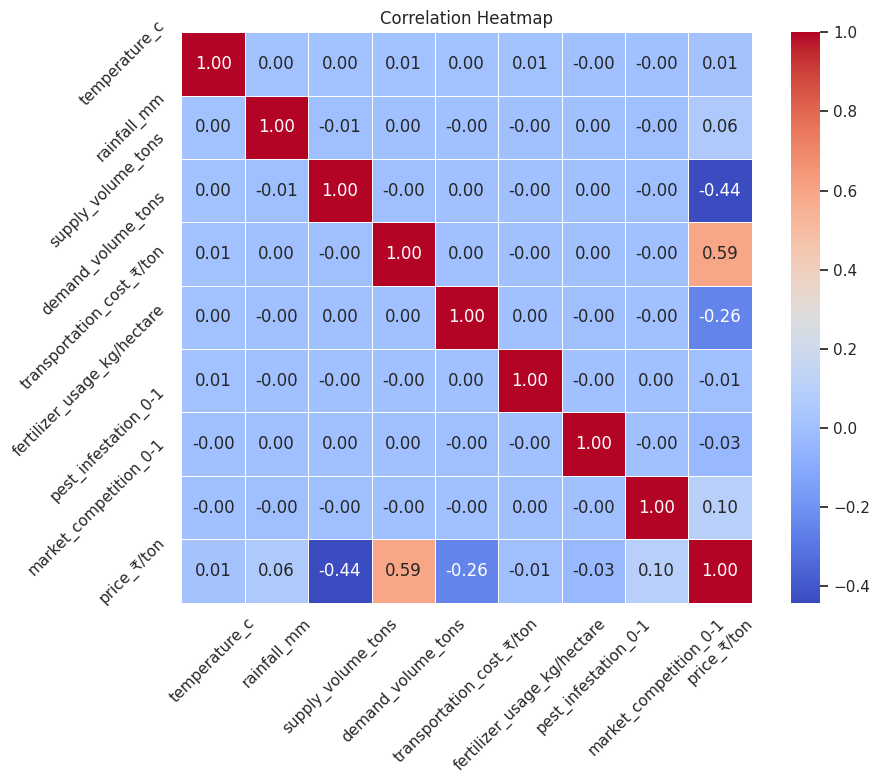

In [27]:
# Correlation Heatmap
plt.figure(figsize=(10, 8))
numeric_df = df.select_dtypes(include=[np.number])  # Select only numeric columns
sns.heatmap(numeric_df.corr(), annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=0.5)
plt.title("Correlation Heatmap")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

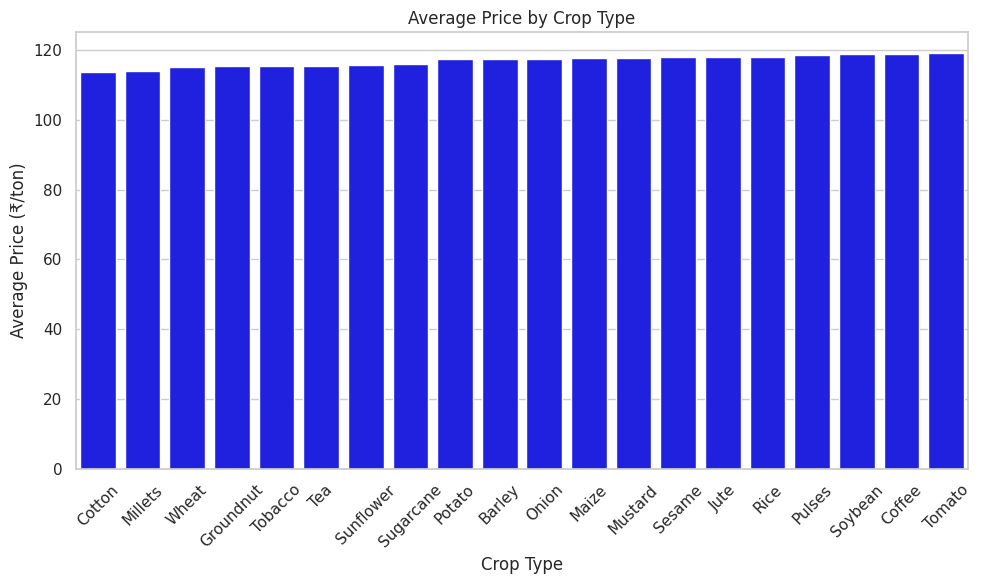

In [28]:
# Bar Plot: Average Price by Crop Type
plt.figure(figsize=(10, 6))
avg_price_by_crop = df.groupby('crop_type')['price_₹/ton'].mean().sort_values()
sns.barplot(x=avg_price_by_crop.index, y=avg_price_by_crop.values, color='blue')
plt.title("Average Price by Crop Type")
plt.xlabel("Crop Type")
plt.ylabel("Average Price (₹/ton)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

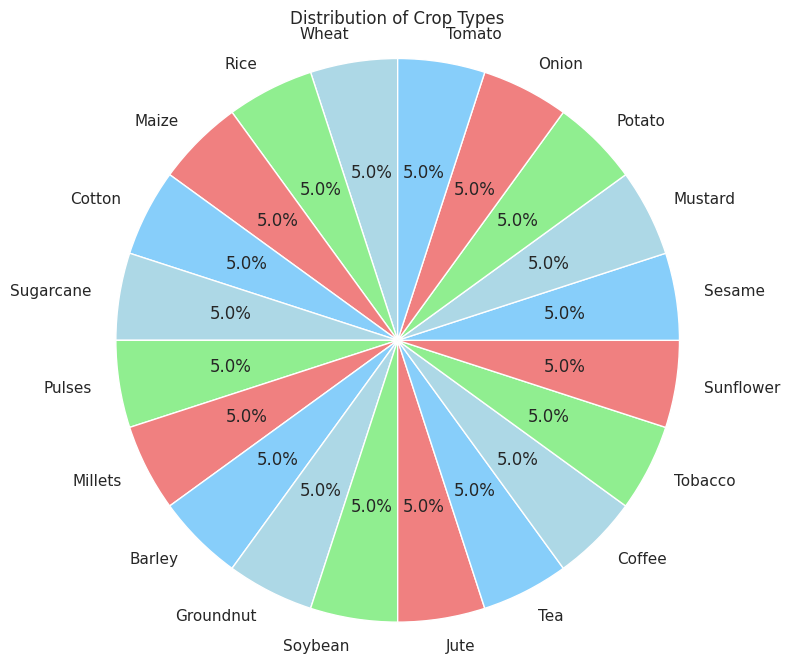

In [29]:
# Pie Chart: Distribution of Crop Types
plt.figure(figsize=(8, 8))
crop_counts = df['crop_type'].value_counts()
plt.pie(crop_counts, labels=crop_counts.index, autopct='%1.1f%%', startangle=90, colors=['lightblue', 'lightgreen', 'lightcoral', 'lightskyblue'])
plt.title("Distribution of Crop Types")
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

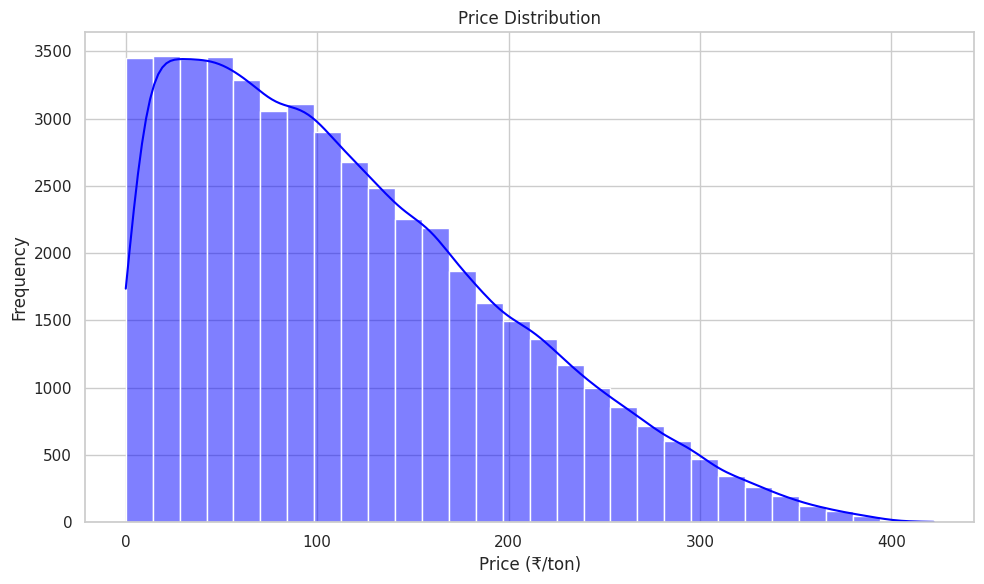

In [30]:
# Histogram: Price Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['price_₹/ton'], bins=30, kde=True, color='blue')
plt.title("Price Distribution")
plt.xlabel("Price (₹/ton)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

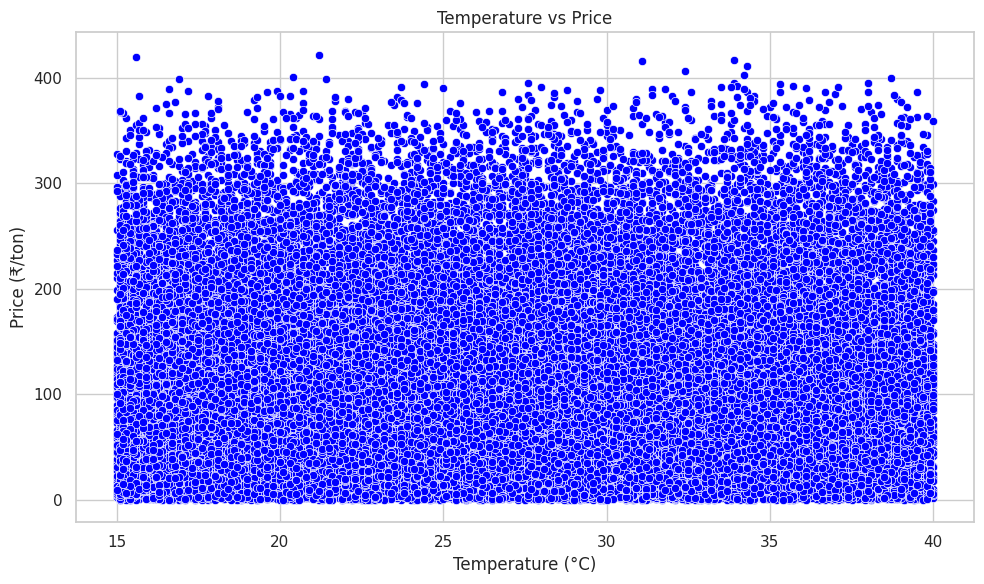

In [31]:
# Scatter Plot: Temperature vs Price
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='temperature_c', y='price_₹/ton', color='blue')
plt.title("Temperature vs Price")
plt.xlabel("Temperature (°C)")
plt.ylabel("Price (₹/ton)")
plt.grid(True)
plt.tight_layout()
plt.show()

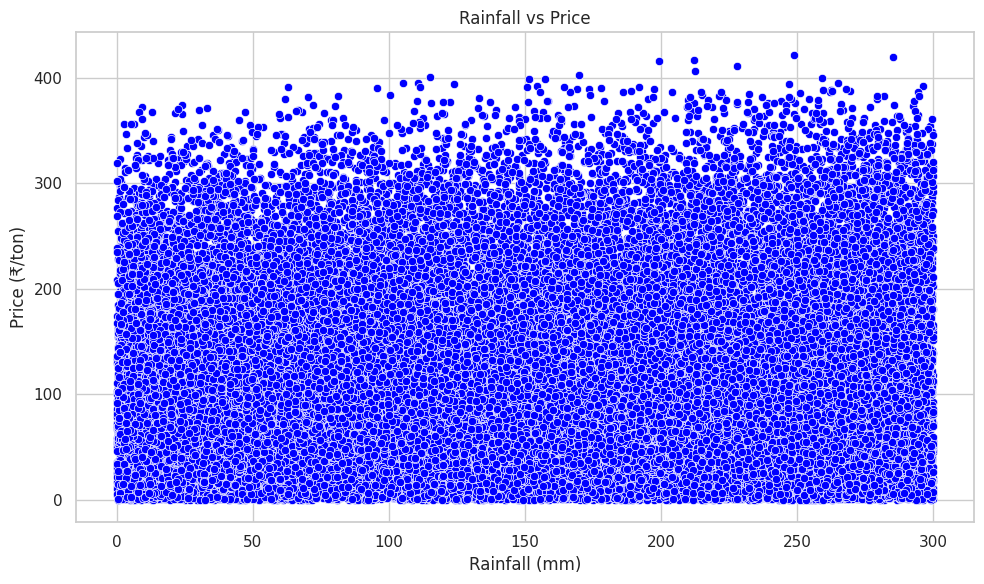

In [32]:
# Scatter Plot: Rainfall vs Price
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='rainfall_mm', y='price_₹/ton', color='blue')
plt.title("Rainfall vs Price")
plt.xlabel("Rainfall (mm)")
plt.ylabel("Price (₹/ton)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [36]:
# Function to load and preprocess data
def load_and_preprocess_data(file):
    df = pd.read_csv(file)
    df['date'] = pd.to_datetime(df['date'])  # Convert date column to datetime
    df = df.dropna()  # Drop rows with missing values
    df = pd.get_dummies(df, columns=['state', 'city', 'crop_type', 'season'])  # One-hot encoding
    return df

In [37]:
# Function for Exploratory Data Analysis
def plot_correlation_matrix(df):
    plt.figure(figsize=(10, 8))
    numeric_df = df.select_dtypes(include=[np.number])  # Select only numeric columns
    sns.heatmap(numeric_df.corr(), annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=0.5)
    plt.title("Correlation Heatmap")
    plt.show()

In [38]:
# Function to train the XGBoost model
def train_xgboost_model(df):
    # Define features and target variable
    X = df.drop(['price_₹/ton'], axis=1)
    y = df['price_₹/ton']

    # Train Test Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train XGBoost Model
    model = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)
    model.fit(X_train, y_train)

    # Predict and Evaluate
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    return model, r2, mae, rmse

In [39]:
# Function to make predictions
def make_prediction(model, input_data):
    input_df = pd.DataFrame([input_data])
    predicted_price = model.predict(input_df)
    return predicted_price[0]

In [42]:
# Function to save the model
def save_model(model, filename):
    joblib.dump(model, filename)
    print(f"Model saved to {filename}")

In [43]:
# Function to load the model
def load_model(filename):
    model = joblib.load(filename)
    print(f"Model loaded from {filename}")
    return model

In [49]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd

def preprocess(df):
    # Handle date
    df['year'] = pd.to_datetime(df['date']).dt.year
    df['month'] = pd.to_datetime(df['date']).dt.month
    df = df.drop('date', axis=1)

    # Encode categorical features
    for col in df.select_dtypes(include='object').columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])

    return df

def main():
    # Preprocess the dataset
    df_processed = preprocess(df)

    # Train XGBoost Model
    model, r2, mae, rmse = train_xgboost_model(df_processed)

    # Display Evaluation Metrics
    print(f"R² Score: {r2:.2f}")
    print(f"Mean Absolute Error: {mae:.2f}")
    print(f"Root Mean Squared Error: {rmse:.2f}")

    # Save the model
    save_model(model, 'xgboost_agricultural_price_model.pkl')

    # Input for prediction
    print("\nEnter the following details for prediction:")
    input_data = {}
    for column in df.columns:
        if column != 'price_₹/ton':
            while True:
                try:
                    value = input(f"Enter {column}: ")
                    input_data[column] = float(value)  # Convert input to float
                    break  # Exit the loop if input is valid
                except ValueError:
                    print("Invalid input. Please enter a numeric value.")

    # Make prediction
    predicted_price = make_prediction(model, input_data)
    print(f"\nPredicted Price: ₹{predicted_price:.2f}")

if __name__ == "__main__":
    main()

R² Score: 0.98
Mean Absolute Error: 8.08
Root Mean Squared Error: 11.05
Model saved to xgboost_agricultural_price_model.pkl

Enter the following details for prediction:
Enter date: 1
Enter state: 1
Enter city: 1
Enter crop_type: 1
Enter season: 1
Enter temperature_c: 1
Enter rainfall_mm: 1
Enter supply_volume_tons: 1
Enter demand_volume_tons: 1
Enter transportation_cost_₹/ton: 1
Enter fertilizer_usage_kg/hectare: 1
Enter pest_infestation_0-1: 1
Enter market_competition_0-1: 1
Enter year: 1
Enter month: 2


ValueError: feature_names mismatch: ['state', 'city', 'crop_type', 'season', 'temperature_c', 'rainfall_mm', 'supply_volume_tons', 'demand_volume_tons', 'transportation_cost_₹/ton', 'fertilizer_usage_kg/hectare', 'pest_infestation_0-1', 'market_competition_0-1', 'year', 'month'] ['date', 'state', 'city', 'crop_type', 'season', 'temperature_c', 'rainfall_mm', 'supply_volume_tons', 'demand_volume_tons', 'transportation_cost_₹/ton', 'fertilizer_usage_kg/hectare', 'pest_infestation_0-1', 'market_competition_0-1', 'year', 'month']
training data did not have the following fields: date